# Text-to-SQL Chain with Query Examples and Table Descriptions V2
### DB: AWS S3
### SQL: AWS Athena
### Chat History Storage: AWS DynamoDB
### LLM: GPT-4

## Chain:

In [1]:
import getpass
import os
import json
import boto3

from typing import List

import pandas as pd
import matplotlib.pyplot as plt

import openai
import anthropic
from langchain.globals import set_debug
from langchain_openai import ChatOpenAI
from langchain.output_parsers.json import SimpleJsonOutputParser
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.chat_message_histories import (
    DynamoDBChatMessageHistory,
)
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents import tool
from langchain.agents import AgentExecutor

from sqlalchemy import create_engine
from urllib.parse import quote_plus

#set environmental variable for OpenAI API key
#os.environ["OPENAI_API_KEY"] = getpass.getpass()
os.environ["OPENAI_API_KEY"] = "sk-proj-69WstrZLIgwAEO413QYoT3BlbkFJyPjAmZezAQBuAsctMweZ"

#### set up AWS S3 and Athena for Database Access

In [2]:
def load_db():
    #database info
    AWS_REGION = "us-east-1"
    SCHEMA_NAME = "wnba_db"
    S3_STAGING_DIR = "s3://wnbadata/"
    
    connect_str = "awsathena+rest://athena.{region_name}.amazonaws.com:443/{schema_name}?s3_staging_dir={s3_staging_dir}"
    
    #connect to AWS athena
    engine = create_engine(connect_str.format(
            region_name=AWS_REGION,
            schema_name=SCHEMA_NAME,
            s3_staging_dir=quote_plus(S3_STAGING_DIR)
    ))
    
    #create SQL db object
    return SQLDatabase(engine)

In [37]:
#create a Pydantic Base Model
class Table(BaseModel):
    """Table in SQL database."""
    name: str = Field(description = "Name of table in SQL database.")

#create table chain
class TableChain:
    def __init__(self, model_name):
        self.model_name = model_name
        self.table_chain = self.create_table_chain()

    def get_table_details(self):
        file_paths = [
            "src/wnba_nba_pbp_data_dict.json",
            "src/wnba_player_box.json",
            "src/wnba_player_info.json",
            "src/wnba_schedule.json",
            "src/wnba_teambox.json"
        ]
        
        table_details = ""
    
        for file_path in file_paths:
            
            #load table names and descriptions from json
            f = open(file_path)
            table_dict = json.load(f)
            
            #retrieve table names and descriptions and compile into string
            table_details = table_details + "Table Name:" + table_dict['table_name'] + "\n" \
            + "Table Description:" + table_dict['table_description']
    
            for col in table_dict['values']:
                table_details = table_details + "\n" + "Column Name:" + col['column_name'] + "\n" \
                + "Column Description:" + col['column_description'] + "\n" \
                + "COlumn Type:" + col['column_type']
            
            table_details = table_details + "\n\n"
        
        return table_details

    def create_table_chain(self):
        
        table_details = self.get_table_details()
        
        #create table chain prompt
        table_prompt_system = f"""Refer the Above Context and Return the names of SQL Tables that MIGHT be relevant to the above context\n\n 
        The tables are:
        
        {table_details}
         """
        
        table_details_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", table_prompt_system),
                ("human", "{input}"),
            ]
        )
        
        #set up LLM
        if "claude" in self.model_name:
            table_chain_llm = ChatAnthropic(model = self.model_name, temperature = 0)
        else:
            table_chain_llm = ChatOpenAI(model_name = self.model_name, temperature = 0)
        table_chain_llm_wtools = table_chain_llm.bind_tools([Table])
        output_parser = PydanticToolsParser(tools=[Table])

        #create table chain
        table_chain = table_details_prompt | table_chain_llm_wtools | output_parser

        return table_chain

    def invoke(self, query):
        return self.table_chain.invoke(query)

In [38]:
#create visulization chain
class VisualizationChain:
    def __init__(self, model_name):
        self.model_name = model_name
        self.visualization_chain = self.create_visualization_chain()

    def create_visualization_chain(self):
        json_parser = SimpleJsonOutputParser()
        #set up LLM
        vis_llm = ChatOpenAI(model_name = self.model_name, temperature = 0)
        vis_chain = vis_llm | json_parser
        return vis_chain

    def invoke(self, query):
        vis_prompt = (
            """
            You are a data visualization expert.
            Determine which of table, bar chart, line chart, or no chart required is the most suitable for visualizating the following context.
            
            If it requires drawing a table, reply as follows:
            {"table": {"columns": ["column1", "column2", ...], "data": [[value1, value2, ...], [value1, value2, ...], ...]}}
            
            If the query requires creating a bar chart, reply as follows:
            {"bar": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}
            
            If the query requires creating a line chart, reply as follows:
            {"line": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}
            
            There can only be two types of chart, "bar" and "line".
            
            If you think neither is suitable or itt requires neither, reply as follows:
            {"answer": "I do not know."}
            
            Return all output as a string.
            
            All strings in "columns" list and data list, should be in double quotes,
            
            For example: {"columns": ["title", "ratings_count"], "data": [["Gilead", 361], ["Spider's Web", 5164]]}
            
            Lets think step by step.
            
            Below is the context.
            Context:
            """
            + str(query)
        )
        
        response = self.visualization_chain.invoke(vis_prompt)
        self.plot(response)
        
    def plot(self, response_dict):
        # Check if the response is an answer.
        if "answer" in response_dict:
            return    
        try:
            # Check if the response is a bar chart.
            if "bar" in response_dict:
                data = response_dict["bar"]
                df = pd.DataFrame.from_dict(data)
                plt.bar(df["columns"].values, df["data"].values)
                plt.xticks(rotation = 315)
                plt.show()
            # Check if the response is a line chart.
            elif "line" in response_dict:
                data = response_dict["line"]
                df = pd.DataFrame.from_dict(data)
                plt.plot(df["columns"].values, df["data"].values)
                plt.xticks(rotation = 315)
                plt.show()
            # Check if the response is a table.
            elif "table" in response_dict:
                data = response_dict["table"]
                df = pd.DataFrame(data["data"], columns = data["columns"])
                plt.table(cellText = df.values, colLabels = df.columns, loc='center')
                plt.axis("off")
                plt.show()
        except ValueError as e:
            return

In [39]:
#create text2sql chain
class QAEngine:
    def __init__(self, model_name, db, session_id, user_id):
        self.model_name = model_name
        self.db = db
        self.chat_history = None
        self.load_chat_history(session_id, user_id)
        self.query_examples = self.load_query_examples()
        self.table_chain = TableChain(model_name)
        self.visualization_chain = VisualizationChain(model_name)
        self.text_sql_agent, self.sql_tools = self.create_text_sql_agent()

    def update_db(self, db):
        self.db = db

    def load_chat_history(self, session_id, user_id):
        #set up dynamodb
        dynamodb = boto3.resource("dynamodb")
        
        sessionid = f"session_id::{session_id}"
        userid = f"{user_id:04}"
        
        #create composite key (session id & user id) for accessing databases
        composite_key = {
            "SessionId": sessionid,
            "UserID": userid,
        }
        
        #query DynamoDB for chat history using the composite key
        chat_history = DynamoDBChatMessageHistory(
            table_name = "Chat_Table",
            session_id = "0",
            key = composite_key,
            history_size = 6,
        )

        self.chat_history = chat_history

    def load_query_examples(self):
        #load query examples from json
        f = open("src/query_example.json")
        query_examples_json = json.load(f)
        
        return query_examples_json["query_examples"]

    def create_text_sql_agent(self):
        #set up LLM
        if "claude" in self.model_name:
            llm = ChatAnthropic(model = self.model_name, temperature = 0)
        else:
            llm = ChatOpenAI(model_name = self.model_name, temperature= 0)
        #utilize langchain agent toolkit: SQL toolkit
        toolkit = SQLDatabaseToolkit(db = self.db, llm = llm)
        tools = toolkit.get_tools()
        llm_with_tools = llm.bind_tools(tools)
        
        #create few shot prompt with query examples
        example_prompt = ChatPromptTemplate.from_messages(["User input: {input}\nSQL query: {query}"])
        few_shot_prompt = FewShotChatMessagePromptTemplate(
            examples = self.query_examples,
            example_prompt = example_prompt,
        )
        
        #create prompt for agent
        prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                """You are an agent designed to interact with a SQL database and a WNBA expert to answer questions about the WNBA.
                Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
                If applicable, return the statistical numbers as well.
                You should also leverage your pre-existing knowledge of WNBA rules, statistics, teams, players, and history to understand and interpret user questions and your answer accurately.
                Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
                You can order the results by a relevant column to return the most interesting examples in the database.
                Never query for all the columns from a specific table, only ask for the relevant columns given the question.
                You have access to tools for interacting with the database.
                Base your final answer on the information returned by these tools, combined with your existing knowledge of the WNBA.
                You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
        
                When referring to a specific game, DO NOT just provide the game ID. You MUST also provide the two teams involved in the game.
                
                DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
        
                DO NOT give me the SQL query.
                
                You MUST always execute the query and use the result to contruct the final answer.
                
                To start you should ALWAYS look at the tables in the database to see what you can query.
                Do NOT skip this step.
                Then you should query the schema of the most relevant tables.
                Here is the relevant table info, but feel free to use other tables you deem necessary: {table_names_to_use}.""",
            ),
            few_shot_prompt,
            MessagesPlaceholder(variable_name = "chat_history"),
            ("user", "{input}"),
            #message placeholder for storing intermediate steps
            MessagesPlaceholder(variable_name = "agent_scratchpad"),
        ])

        #create agent
        agent = (
            {
                "input": lambda x: x["input"],
                "agent_scratchpad": lambda x: format_to_openai_tool_messages(
                    x["intermediate_steps"]
                ),
                "chat_history": lambda x: x["chat_history"],
                "table_names_to_use": lambda x: x["table_names_to_use"],
            }
            | prompt
            | llm_with_tools
            | OpenAIToolsAgentOutputParser()
        )
        
        return agent, tools

    def invoke(self, query):
        response = None
        max_iteration = 10
        error_count = 0
        count = 0
        agent_executor = AgentExecutor(agent = self.text_sql_agent, tools = self.sql_tools, verbose = False, return_intermediate_steps = True, max_iterations = max_iteration)
        while response is None and count <= 5:
            try:
                response = agent_executor.invoke({
                    "input": query,
                    "chat_history": self.chat_history.messages,
                    #passing result of table chain to text2sql agent
                    "table_names_to_use": self.table_chain.invoke(query)
                })
            except (openai.BadRequestError, openai.APIError, anthropic.APIStatusError) as e:
                if error_count == 0:
                    max_iteration = 5
                elif error_count == 1:
                    max_iteration = 1
                agent_executor = AgentExecutor(agent = self.text_sql_agent, tools = self.sql_tools, verbose = False, return_intermediate_steps = True, max_iterations = max_iteration)
                error_count += 1
                count += 1
            except Exception as e:
                if response is not None and ('SQL query' in response['output'] or 'Agent stopped' in response['output']):
                    response = None
                    count += 1
            else:
                if 'SQL query' in response['output'] or 'Agent stopped' in response['output']:
                    response = None
                    count += 1
                    
        if response is not None:
            self.chat_history.add_user_message(query)
            self.chat_history.add_ai_message(response["output"])
            self.visualization_chain.invoke(response["output"])
            return response['output']
        else:
            self.chat_history.add_user_message(query)
            self.chat_history.add_ai_message("no response")
            return "no response"

In [40]:
awsdb = load_db()
gpt4T_text2sql = QAEngine("gpt-4o-mini", awsdb, 205, 1)

/var/folders/1c/ybx_8cds1ybgdg3z19ptmmk00000gn/T/ipykernel_92750/3112801148.py:10: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pyathena.sqlalchemy.rest.AthenaRestDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(connect_str.format(


>>>  How many triple-doubles were recorded in the WNBA between 2018 and 2024, and who had the most triple-doubles?


loading response....
Response: Between 2018 and 2024, there were a total of 12 triple-doubles recorded in the WNBA. The player with the most triple-doubles during this period was **Alyssa Thomas**, who achieved this feat 12 times. Other notable players include **Sabrina Ionescu** with 4 triple-doubles, and **Courtney Vandersloot**, **Candace Parker**, and **Chelsea Gray**, each with 2 triple-doubles.


>>>  How did the average points per game of the top 3 scorers change each season from 2018 to 2024?


loading response....


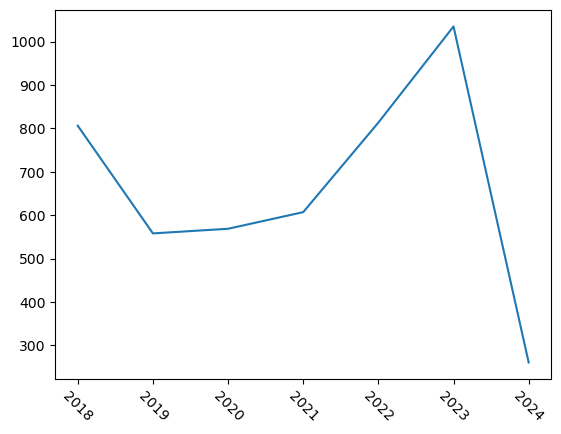

Response: The average points per game of the top 3 scorers in the WNBA from 2018 to 2024 are as follows:

- **2018**: 806.0 points
- **2019**: 558.0 points
- **2020**: 568.67 points
- **2021**: 607.0 points
- **2022**: 813.33 points
- **2023**: 1034.67 points
- **2024**: 260.67 points

### Breakdown of Top Scorers by Season:
1. **2018**:
   - DeWanna Bonner: 769 points
   - Breanna Stewart: 949 points
   - A'ja Wilson: 700 points

2. **2019**:
   - A'ja Wilson: 497 points
   - DeWanna Bonner: 619 points

3. **2020**:
   - Breanna Stewart: 548 points
   - DeWanna Bonner: 542 points
   - A'ja Wilson: 616 points

4. **2021**:
   - Breanna Stewart: 601 points
   - A'ja Wilson: 663 points
   - DeWanna Bonner: 557 points

5. **2022**:
   - A'ja Wilson: 933 points
   - Breanna Stewart: 917 points
   - DeWanna Bonner: 590 points

6. **2023**:
   - Breanna Stewart: 1125 points
   - A'ja Wilson: 1155 points
   - DeWanna Bonner: 824 points

7. **2024**:
   - Breanna Stewart: 246 points
   - A'ja 

>>>  bye


In [41]:
input_text = input('>>> ')
while input_text.lower() != 'bye':
    if input_text:
        
        print("loading response....")
        
        response = gpt4T_text2sql.invoke(input_text)

        print("Response: " + response)
    input_text = input('>>> ')